In [806]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
import lightgbm as lgbm

In [749]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df = pd.concat([train_df, test_df], axis=0)

In [750]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [751]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [752]:
df.MSSubClass.value_counts()

20     1079
60      575
50      287
120     182
30      139
70      128
160     128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

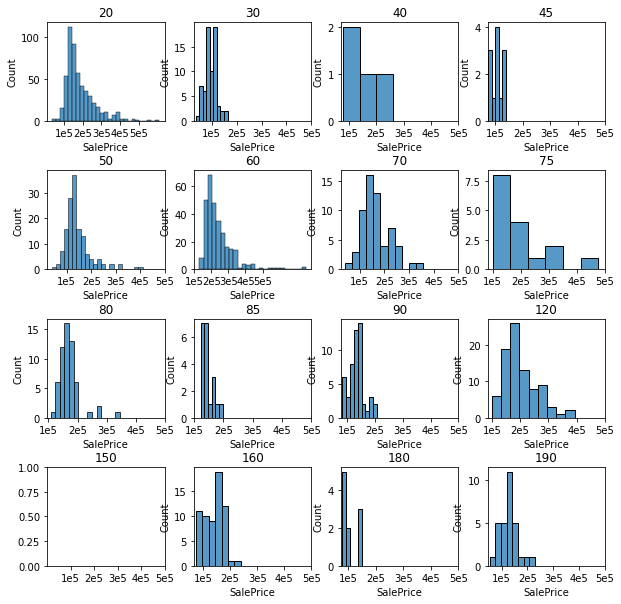

<Figure size 432x288 with 0 Axes>

In [753]:
fig = plt.figure(figsize=(10, 10))
temp_train_df = df.head(1460)
types = sorted(df.MSSubClass.unique())

for i in range(16):
    plt.subplot(4, 4, i+1)
    subclassnum = types[i]
    sns.histplot(x='SalePrice', data=temp_train_df[temp_train_df.MSSubClass == subclassnum])
    plt.title(subclassnum)
    plt.xticks(ticks=(100000, 200000, 300000, 400000, 500000), labels=('1e5', '2e5', '3e5', '4e5', '5e5'))

plt.subplots_adjust(hspace=0.5, wspace=0.25)
plt.show()
plt.clf()

In [754]:
MSMap = {20: 1, 50: 1, 60: 1, 120: 1, 150: 1, 70: 2, 75: 2, 80: 2, 160: 2, 30: 3, 40: 3, 45: 3, 85: 3, 90: 3, 180: 3, 190: 3}
df['MSSubClassGroup'] = df['MSSubClass'].map(MSMap)
df['MSSubClassGroup'].value_counts()

1    2124
3     398
2     397
Name: MSSubClassGroup, dtype: int64

In [755]:
df.MSZoning.fillna(df.MSZoning.mode()[0], inplace=True)
df.MSZoning.value_counts()
# unsure how to turn this into some useful feature 

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

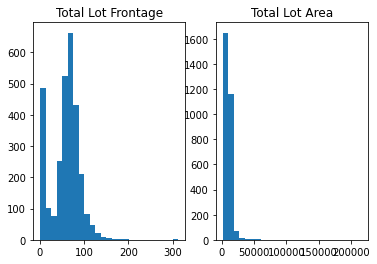

<Figure size 432x288 with 0 Axes>

In [756]:
df.LotFrontage.fillna(0, inplace=True)
df.LotArea.fillna(0, inplace=True)

plt.subplot(1, 2, 1)
plt.hist(df['LotFrontage'], bins=25)
plt.title('Total Lot Frontage')
plt.subplot(1, 2, 2)
plt.hist(df['LotArea'], bins=25)
plt.title('Total Lot Area')

plt.show()
plt.clf()

Some big outliers for that ^ but generally larger area = more money, so probably useable with some finetuning - log scale

Wood deck area: 1396
Open porch area: 1621
Enclosed porch area: 459
3 Season porch area: 37
Screen porch area: 256


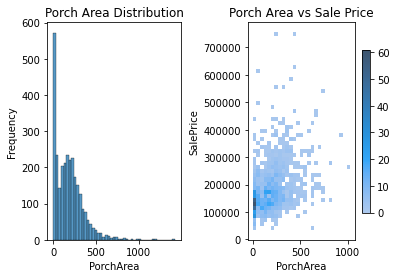

<Figure size 432x288 with 0 Axes>

In [757]:
# assuming 0 = no porch of that type
print("Wood deck area:", (df['WoodDeckSF'] != 0).sum())
print("Open porch area:", (df['OpenPorchSF'] != 0).sum())
print("Enclosed porch area:", (df['EnclosedPorch'] != 0).sum())
print("3 Season porch area:",  (df['3SsnPorch'] != 0).sum())
print("Screen porch area:", (df['ScreenPorch'] != 0).sum())

df['PorchArea'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# print(df.PorchArea)

ax = plt.subplot(1, 2, 1)
sns.histplot(df.PorchArea)
plt.ylabel('Frequency')
plt.title("Porch Area Distribution")
ax2 = plt.subplot(1, 2, 2)
sns.histplot(x='PorchArea', y='SalePrice', data=df.head(1460), cbar=True, cbar_kws=dict(shrink=.75))
plt.subplots_adjust(wspace=0.5)
plt.title('Porch Area vs Sale Price')
plt.show()
plt.clf()

There seems to be a positive correlation between cumulative porch area and sale price of the houses, so it is potentially a workable feature. 

Might want to weight the different types of porches - some might be more expensive, need research

In [758]:
print("Different pool area values")
print(sorted(df.PoolArea.unique()))
print((df['PoolArea'] == 0).sum())

Different pool area values
[0, 144, 228, 368, 444, 480, 512, 519, 555, 561, 576, 648, 738, 800]
2906


There are very few houses (13) in the dataset at all that have a pool. 

Could either make a hasPool feature or ignore completely (considering too little data to fit useful information, would overfit)

In [759]:
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df.HasPool.value_counts()

0    2906
1      13
Name: HasPool, dtype: int64

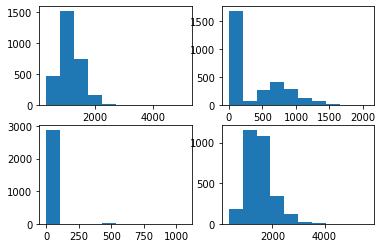

<Figure size 432x288 with 0 Axes>

In [760]:
plt.subplot(2, 2, 1)
plt.hist(df['1stFlrSF'])
plt.subplot(2, 2, 2)
plt.hist(df['2ndFlrSF'])
plt.subplot(2, 2, 3)
plt.hist(df['LowQualFinSF'])
plt.subplot(2, 2, 4)
plt.hist(df['GrLivArea'])
plt.show()
plt.clf()

df[['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']].head()
# 1stFlrSF and 2ndFlrSF just seem to add up to GrLivArea - only use GrLivArea
# lower quality area counts less 
df['LivingArea'] = df['GrLivArea'] + 0.25*df['LowQualFinSF']

In [761]:
# 103 rich people with a misc thing - i think better just to make a boolean
# df.MiscVal[df.MiscVal != 0].count()
df['HasMisc'] = df.MiscVal.apply(lambda x: 1 if x != 0 else 0)
df.HasMisc.value_counts()

0    2816
1     103
Name: HasMisc, dtype: int64

In [762]:
areaCols = ['LotFrontage', 'LotArea', 'LivingArea', 'PorchArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
]
for col in areaCols:
    df[col].fillna(df[col].median(), inplace=True)
    df[col] = np.log10(df[col] + 1)

In [763]:
print(df[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']].head())
df['TotAreasAbvGrd'] = df['FullBath'] + 0.5*df['HalfBath'] + df['KitchenAbvGr'] + df['TotRmsAbvGrd']

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0           1.0           0.0         2         1             3             1   
1           0.0           1.0         2         0             3             1   
2           1.0           0.0         2         1             3             1   
3           1.0           0.0         1         0             3             1   
4           1.0           0.0         2         1             4             1   

   TotRmsAbvGrd  
0             8  
1             6  
2             6  
3             7  
4             9  


In [764]:
df.GarageCars = df.GarageCars.map(lambda x: 3.0 if x == 5.0 or x == 4.0 else x)
df['GarageCars'].fillna(df.GarageCars.mode()[0], inplace=True)
df.GarageCars.value_counts()

2.0    1595
1.0     776
3.0     391
0.0     157
Name: GarageCars, dtype: int64

In [765]:
df['HouseAge'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']

In [766]:
qualityValues = {'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}

qualityCols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']

for col in qualityCols:
    df[col] = df[col].map(qualityValues)
    df[col].fillna(6, inplace=True)

df.BsmtFinType1.value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

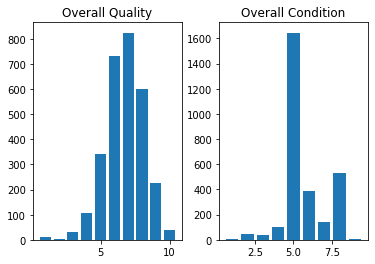

In [767]:
#bar or pie OverallQual & OverallCond
plt.subplot(1, 2, 1)
plt.bar(df['OverallQual'].unique(), df['OverallQual'].value_counts())
plt.title('Overall Quality')
plt.subplot(1, 2, 2)
plt.bar(df['OverallCond'].unique(), df['OverallCond'].value_counts())
plt.title('Overall Condition')
plt.subplots_adjust(wspace=0.25)

In [768]:
saleMap = {'COD': 0, 'ConLD': 0, 'ConLI': 0, 'ConLw': 0, 'Con': 0, 'Oth': 0, 'WD': 1, 'CWD': 1, 'New': 2}
df['SaleType'] = df['SaleType'].map(saleMap)
df['SaleType'].fillna(0, inplace=True)
df['SaleType'].value_counts()

1.0    2537
2.0     239
0.0     143
Name: SaleType, dtype: int64

In [769]:
df['SaleCondition'] = df['SaleCondition'].map({'Normal': 0, 'Abnorml': 2, 'AdjLand': 2, 'Alloca': 2, 'Family': 2, 'Partial': 1})
df['SaleCondition'].value_counts()


0    2402
2     272
1     245
Name: SaleCondition, dtype: int64

In [770]:
df['Has2ndBsmt'] = df['BsmtFinSF2'].apply(lambda x: 1 if x != 0 else 0)
df.Has2ndBsmt.value_counts()

0    2572
1     347
Name: Has2ndBsmt, dtype: int64

In [771]:
df['HasGravel'] = df.apply(lambda row: 1 if row['Alley'] == 'Grvl' or row['Street'] == 'Grvl' else 0, axis=1)
df.HasGravel.value_counts()

0    2787
1     132
Name: HasGravel, dtype: int64

In [772]:
df.LotShape = df.LotShape.map({'Reg': 0, 'IR3': 2, 'IR2': 2, 'IR1': 1})
df.LotShape.value_counts()

0    1859
1     968
2      92
Name: LotShape, dtype: int64

In [773]:
df.LandSlope = df.LandSlope.map({'Sev': 0, 'Mod': 1, 'Gtl': 2})
df.LandSlope.value_counts()

2    2778
1     125
0      16
Name: LandSlope, dtype: int64

In [774]:
df.Condition1 = df.Condition1.map({'Norm': 'Normal', 'PosN': 'Positive', 'PosA': 'Positive', 'Feedr': 'Road', 'Artery': 'Road', 'RRAn': 'Railroad', 'RRAe': 'Railroad', 'RRNn': 'Railroad', 'RRNe': 'Railroad'})
df.Condition1.value_counts()
# add condition 2 stuff to make just one condition

Normal      2511
Road         256
Railroad      93
Positive      59
Name: Condition1, dtype: int64

In [775]:
df.HouseStyle = df.HouseStyle.map({'1Story': 1, '1.5Unf': 1, '1.5Fin': 2, '2Story': 2, '2.5Unf': 2, '2.5Fin': 2, 'SFoyer': 3, 'SLvl': 3})
df.HouseStyle.value_counts()

1    1490
2    1218
3     211
Name: HouseStyle, dtype: int64

In [776]:
df.RoofStyle = df.RoofStyle.apply(lambda x: 'Other' if x not in ['Gable', 'Hip'] else x)
df.RoofStyle.value_counts()

Gable    2310
Hip       551
Other      58
Name: RoofStyle, dtype: int64

In [777]:
df.Exterior1st = df.Exterior1st.apply(lambda x: 'Other' if x not in ['VinylSd', 'MetalSd', 'HdBoard', 'Wd Sdng', 'Plywood', 'CemntBd'] else x)
df.Exterior2nd = df.Exterior2nd.apply(lambda x: 'Other' if x not in ['VinylSd', 'MetalSd', 'HdBoard', 'Wd Sdng', 'Plywood', 'CemntBd'] else x)
df.Exterior1st.value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Other       244
Plywood     221
CemntBd     126
Name: Exterior1st, dtype: int64

In [778]:
df.MasVnrType = df.MasVnrType.apply(lambda x: 'Brk' if 'Brk' in str(x) else x)
df.MasVnrType.fillna('None')
df.MasVnrType.value_counts()

None     1742
Brk       904
Stone     249
Name: MasVnrType, dtype: int64

In [779]:
df.Foundation = df.Foundation.apply(lambda x: 'Other' if x in ['Slab', 'Stone', 'Wood'] else x)
df.Foundation.value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Other       65
Name: Foundation, dtype: int64

In [780]:
bsmtValues = {'GLQ': 1, 'ALQ': 2, 'Rec': 2, 'BLQ': 3, 'LwQ': 4, 'Unf': 5, 'NA': 5}

for col in ['BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].map(bsmtValues)
    df[col].fillna(5, inplace=True)

df.BsmtFinType1.value_counts()

5.0    930
1.0    849
2.0    717
3.0    269
4.0    154
Name: BsmtFinType1, dtype: int64

In [781]:
df.CentralAir = df.CentralAir.map({'Y': 1, 'N': 0})
df.CentralAir.value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

In [782]:
df.Electrical = df.Electrical.map({'SBrkr': 0, 'FuseA': 1, 'FuseF': 1, 'FuseP': 1, 'Mix': 1})
df.Electrical.fillna(df.Electrical.mode()[0], inplace=True)
df.Electrical.value_counts()

0.0    2672
1.0     247
Name: Electrical, dtype: int64

In [783]:
df['BsmtBath'] = df['BsmtFullBath'] + df['BsmtHalfBath']*0.5
df['BsmtBath'].fillna(0, inplace=True)
df['Bathrooms'] = df['FullBath'] + df['HalfBath']*0.5

In [784]:
df.GarageType = df.GarageType.apply(lambda x: 'InHouse' if x in ['BuiltIn', 'CarPort', 'Basement', '2Types'] else x)
df.GarageType.fillna('None', inplace=True)
df.GarageType.value_counts()

# do anything w/ GarageYrBlt??

Attchd     1723
Detchd      779
InHouse     224
None        157
Basment      36
Name: GarageType, dtype: int64

In [785]:
df.GarageFinish.fillna('NA', inplace=True)
df.GarageFinish.value_counts()

Unf    1230
RFn     811
Fin     719
NA      159
Name: GarageFinish, dtype: int64

In [786]:
df.PavedDrive = df.PavedDrive.apply(lambda x: 0 if x == 'N' else 1)
df.PavedDrive.value_counts()

1    2703
0     216
Name: PavedDrive, dtype: int64

In [787]:
df['FenceQual'] = df['Fence'].map({'GdPrv': 1, 'GdWo': 1, 'MnPrv': 2, 'MnWw': 2})
df['FenceQual'].fillna(3, inplace=True)
df['HasFence'] = df['FenceQual'].apply(lambda x: 1 if x != 3 else 0)
df.FenceQual.value_counts()

3.0    2348
2.0     341
1.0     230
Name: FenceQual, dtype: int64

In [788]:
get_dummies_cols = ['LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'GarageType', 'GarageFinish']
df_dummies = pd.get_dummies(df, columns=get_dummies_cols)
df_dummies.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,...,Foundation_PConc,GarageType_Attchd,GarageType_Basment,GarageType_Detchd,GarageType_InHouse,GarageType_None,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf
0,1,60,RL,1.819544,3.926908,Pave,NaN,0,AllPub,2,...,1,1,0,0,0,0,0,0,1,0
1,2,20,RL,1.908485,3.982316,Pave,NaN,0,AllPub,2,...,0,1,0,0,0,0,0,0,1,0
2,3,60,RL,1.838849,4.051191,Pave,NaN,1,AllPub,2,...,1,1,0,0,0,0,0,0,1,0
3,4,70,RL,1.785330,3.980049,Pave,NaN,1,AllPub,2,...,0,0,0,1,0,0,0,0,0,1
4,5,60,RL,1.929419,4.154150,Pave,NaN,1,AllPub,2,...,1,1,0,0,0,0,0,0,1,0


In [789]:
features = ['MSSubClassGroup', 'HasMisc', 'TotAreasAbvGrd', 'GarageCars', 'HouseAge', 'RemodelAge', 'YrSold', 'MoSold', 'OverallCond', 'OverallQual', 'SaleType', 'SaleCondition', 'Has2ndBsmt', 'HasPool', 'HasGravel', 'LotShape', 'LandSlope', 'HouseStyle', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'BsmtBath', 'Bathrooms', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'PavedDrive', 'FenceQual', 'HasFence']
features += areaCols + qualityCols + get_dummies_cols

# features

In [790]:
len(features)

68

In [791]:
train = df.iloc[:1460,:]
test = df.iloc[1460:, :]

X_train = train[features]
y_train = train['SalePrice']
X_test = test[features]

In [792]:
X_train = pd.get_dummies(X_train, columns=get_dummies_cols)
X_test = pd.get_dummies(X_test, columns=get_dummies_cols)


In [793]:
X_train.head()

,MSSubClassGroup,HasMisc,TotAreasAbvGrd,GarageCars,HouseAge,RemodelAge,YrSold,MoSold,OverallCond,OverallQual,...,Foundation_PConc,GarageType_Attchd,GarageType_Basment,GarageType_Detchd,GarageType_InHouse,GarageType_None,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf
0,1,0,11.5,2.0,5,5,2008,2,5,7,...,1,1,0,0,0,0,0,0,1,0
1,1,0,9.0,2.0,31,31,2007,5,8,6,...,0,1,0,0,0,0,0,0,1,0
2,1,0,9.5,2.0,7,6,2008,9,5,7,...,1,1,0,0,0,0,0,0,1,0
3,2,0,9.0,3.0,91,36,2006,2,5,7,...,0,0,0,1,0,0,0,0,0,1
4,1,0,12.5,3.0,8,8,2008,12,5,8,...,1,1,0,0,0,0,0,0,1,0


In [794]:
len(features)

68

In [795]:
kbest = SelectKBest(score_func = f_regression, k = 80)
kbest.fit(X_train, y_train)

SelectKBest(k=80, score_func=<function f_regression at 0x00000191B9105940>)

In [796]:
kbest.get_feature_names_out(X_train.columns)

array(['MSSubClassGroup', 'TotAreasAbvGrd', 'GarageCars', 'HouseAge',
       'RemodelAge', 'OverallQual', 'SaleType', 'HasGravel', 'LotShape',
       'BsmtFinType1', 'Electrical', 'BsmtBath', 'Bathrooms',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'PavedDrive',
       'FenceQual', 'HasFence', 'LotArea', 'LivingArea', 'PorchArea',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ExterQual', 'BsmtQual', 'BsmtCond', 'HeatingQC',
       'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
       'LandContour_HLS', 'LotConfig_CulDSac', 'Neighborhood_BrkSide',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR',
       'Neighborhood_NAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Sawyer', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Normal',
       'Condition1

In [797]:
X_train_fs = kbest.transform(X_train)
X_test_fs = kbest.transform(X_test)
mask = kbest.get_support()
new_features = X_train.columns[mask]
X_train_fs = pd.DataFrame(X_train_fs, columns = new_features)
X_test_fs = pd.DataFrame(X_test_fs, columns = new_features)

In [805]:
feat_imp = list(zip(X_train.columns, clf.feature_importances_))
s_feat_imp = sorted(feat_imp, key = lambda x: x[1], reverse = True)
i = 0
figood = []
for (feat, imp) in s_feat_imp:
    if i < 80:
        figood.append(feat)
    print(feat, imp)
    i += 1

TotalBsmtSF 216
LivingArea 215
LotArea 214
1stFlrSF 173
BsmtFinSF1 157
GarageArea 154
HouseAge 113
PorchArea 111
MasVnrArea 109
OpenPorchSF 97
RemodelAge 92
TotAreasAbvGrd 87
LotFrontage 87
OverallQual 86
2ndFlrSF 71
OverallCond 69
WoodDeckSF 60
MoSold 58
GrLivArea 46
YrSold 44
FireplaceQu 36
GarageCars 34
SaleCondition 32
BsmtFinType1 27
BsmtBath 26
KitchenQual 26
Bathrooms 24
BsmtQual 22
Neighborhood_Crawfor 21
LotShape 19
EnclosedPorch 19
TotRmsAbvGrd 18
ScreenPorch 18
ExterQual 16
HeatingQC 15
Neighborhood_Somerst 15
BedroomAbvGr 14
Neighborhood_NoRidge 12
Neighborhood_BrkSide 11
Neighborhood_StoneBr 11
MasVnrType_Brk 11
SaleType 10
FenceQual 10
Neighborhood_Edwards 10
Condition1_Road 10
GarageType_Detchd 10
MSSubClassGroup 9
BsmtCond 9
Neighborhood_OldTown 9
LandSlope 8
HouseStyle 8
BsmtFinSF2 8
LowQualFinSF 8
Exterior1st_HdBoard 8
Exterior1st_Other 8
GarageFinish_RFn 8
GarageFinish_Unf 8
GarageCond 7
Condition1_Normal 7
Exterior1st_Wd Sdng 7
Electrical 6
KitchenAbvGr 6
LandContou

In [799]:
# 1 am code at its finest
kbestcols = X_train_fs.columns
ficols = figood
# print(kbestcols)
# print(ficols)
for i in kbestcols:
    if i not in ficols:
        print(i)

HasGravel
PavedDrive
HasFence
Neighborhood_IDOTRR
Neighborhood_Sawyer
Neighborhood_Timber
BldgType_Duplex
RoofStyle_Hip
Exterior1st_CemntBd
Exterior2nd_MetalSd
Exterior2nd_VinylSd
Exterior2nd_Wd Sdng
MasVnrType_None
Foundation_CBlock
Foundation_PConc
GarageType_InHouse
GarageType_None
GarageFinish_NA


In [800]:
cols_to_keep = ['LotArea', 'LivingArea', 'TotalBsmtSF', 'BsmtFinSF1', 'GarageArea', '1stFlrSF', 'HouseAge', 'PorchArea', 'MasVnrArea', 'LotFrontage', 'TotAreasAbvGrd', 'RemodelAge', '2ndFlrSF', 'OverallCond', 'OverallQual', 'GrLivArea', 'FireplaceQu', 'GarageCars', 'KitchenQual', 'BsmtQual', 'HeatingQC', 'ExterQual', 'MSSubClassGroup', 'MoSold', 'YrSold', 'SaleType', 'BsmtCond', 'GarageQual', 'GarageCond']
X_train_final = X_train[cols_to_keep]
X_test_final = X_test[cols_to_keep]

In [801]:
X_train_final

,LotArea,LivingArea,TotalBsmtSF,BsmtFinSF1,GarageArea,1stFlrSF,HouseAge,PorchArea,MasVnrArea,LotFrontage,...,BsmtQual,HeatingQC,ExterQual,MSSubClassGroup,MoSold,YrSold,SaleType,BsmtCond,GarageQual,GarageCond
0,3.926908,3.233250,2.932981,2.849419,2.739572,2.932981,5,1.792392,2.294466,1.819544,...,2.0,1,2,1,2,2008,1.0,3.0,3.0,3.0
1,3.982316,3.101403,3.101403,2.990783,2.663701,3.101403,31,2.475671,0.000000,1.908485,...,2.0,1,3,1,5,2007,1.0,3.0,3.0,3.0
2,4.051191,3.252125,2.964260,2.687529,2.784617,2.964260,7,1.633468,2.212188,1.838849,...,2.0,1,2,1,9,2008,1.0,3.0,3.0,3.0
3,3.980049,3.235023,2.879096,2.336460,2.808211,2.983175,91,2.488551,0.000000,1.785330,...,3.0,2,3,2,2,2006,1.0,2.0,3.0,3.0
4,4.154150,3.342225,3.059185,2.816904,2.922725,3.059185,8,2.442480,2.545307,1.929419,...,2.0,1,2,1,12,2008,1.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3.898615,3.216957,2.979548,0.000000,2.663701,2.979548,8,1.612784,0.000000,1.799341,...,2.0,1,3,1,8,2007,1.0,3.0,3.0,3.0
1456,4.119784,3.316809,3.188366,2.898176,2.699838,3.316809,32,2.544068,2.079181,1.934498,...,2.0,3,3,1,2,2010,1.0,3.0,3.0,3.0
1457,3.956313,3.369401,3.061829,2.440909,2.403121,3.075182,69,1.785330,0.000000,1.826075,...,3.0,1,1,2,5,2010,1.0,2.0,3.0,3.0
1458,3.987577,3.033021,3.033021,1.698970,2.382017,3.033021,60,2.680336,0.000000,1.838849,...,3.0,2,3,1,4,2010,1.0,3.0,3.0,3.0


In [810]:
clf = RandomForestRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=kf)
print(scores.mean())
# clf.fit(X_train, y_train)
# clf.feature_importances_

0.8343393995698909


In [809]:
clf = lgbm.LGBMRegressor(random_state=1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=kf)
print(scores.mean())
# clf.fit(X_train, y_train)
# preds = clf.predict(X_test)

0.8506845351824012


In [808]:
clf = BayesianRidge(compute_score=True)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=kf)
print(scores.mean())
# clf.fit(X_train, y_train)
# preds = clf.predict(X_test)

0.82492468024973


In [804]:
output = pd.DataFrame({'Id': test.Id, 'SalePrice': preds})
output.to_csv('submission.csv', index=False)

it keeps on doing worse when it just doenst have the stuff

solution: give literally all the features

^^ add like all of the cat ones skipped before tmrw

also try to give it each of the indiv porch ones also